In [1]:
import matplotlib.pyplot as plt
# import dataprep # this not working
import pandas as pd
import numpy as np
    
# Import the data
signal_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttH/df_ml_inputs.hd5")
background_data = pd.read_hdf("/dice/projects/CMS/Hinv/datasets_for_ml_training/ttBar/df_ml_inputs.hd5")

def prep(signal_data, background_data):

    import pandas as pd
    import numpy as np

    # Remove nan values
    signal_data = signal_data.dropna()
    background_data = background_data.dropna()

    # Remove regions 1-5 as they contain data not suitable for training
    signal_data = signal_data[~signal_data.region.isin([1, 2, 3, 4, 5])]
    background_data = background_data[~background_data.region.isin([1, 2, 3, 4, 5])]

    # Adding in balance weights 

    signal_data['weight_balance'] = len(background_data) / len(signal_data)
    background_data['weight_balance'] = 1

    # Dealing with class imbalance by reducing the number of background events
    # total_background_weight = background_data['weight_nominal'].sum() # Step 1: Calculate total weight for the original background
    # sampled_background = background_data.sample(len(signal_data), random_state=42) # Step 2: Randomly sample x rows from the background data
    # sampled_background_weight = sampled_background['weight_nominal'].sum() # Step 3: Calculate the total weight of the sampled background (before scaling)
    # scaling_factor = total_background_weight / sampled_background_weight # Step 4: Compute the scaling factor to adjust the weights
    # sampled_background['weight_nominal_scaled'] = sampled_background['weight_nominal'] * scaling_factor # Step 5: Scale the weights of the sampled background rows
    # signal_data['weight_nominal_scaled'] = signal_data['weight_nominal'] # Add scaled weight ot the signal data

    # Combine data + add feautures
    # signal_data['target'] = 1
    # sampled_background['target'] = 0
    # data = pd.concat([signal_data, sampled_background])

    # Combine data + add feautures
    signal_data['target'] = 1
    background_data['target'] = 0
    data = pd.concat([signal_data, background_data])

    # Creation of additional useful features found from 'investigatingjets.ipynb'
    # cleanedJet_eta_std, cleanedJet_eta_range, cleadJet_phi_std, cleanedJet_phi_range

    data['cleanedJet_eta_std'] = data['cleanedJet_eta'].apply(lambda x: np.std(x))
    data['cleanedJet_eta_range'] = data['cleanedJet_eta'].apply(lambda x: np.max(x) - np.min(x))
    data['cleanedJet_phi_std'] = data['cleanedJet_phi'].apply(lambda x: np.std(x))
    data['cleanedJet_phi_range'] = data['cleanedJet_phi'].apply(lambda x: np.max(x) - np.min(x))

    return data

data = prep(signal_data, background_data)

In [3]:
# List of variables to use for training
features = ['DiJet_mass', 'HT', 'InputMet_InputJet_mindPhi',
       'InputMet_pt', 'MHT_pt', 'MinChi',
       'MinOmegaHat', 'MinOmegaTilde', 'cleanedJet_eta_std', 'cleanedJet_eta_range',
       'cleanedJet_phi_range', 'cleanedJet_phi_std', 'ldphi_bjet',
       'ldphi_jet', 'ncleanedBJet', 'ncleanedJet', 'region', 'sdphi_bjet',
       'sdphi_jet']

# weights_copy = data['weight_nominal_scaled'].copy() # Use this one for saving the weights when balancing by removing 

weights_copy = data['weight_nominal'].copy() # Use this one for saving the weights when balancing by adding weight_balance

Epoch [1/35], Training Loss: 0.7240, Validation Loss: 0.7056
Epoch [2/35], Training Loss: 0.7065, Validation Loss: 0.6968
Epoch [3/35], Training Loss: 0.7030, Validation Loss: 0.6956
Epoch [4/35], Training Loss: 0.6996, Validation Loss: 0.6929
Epoch [5/35], Training Loss: 0.6976, Validation Loss: 0.6930
Epoch [6/35], Training Loss: 0.6968, Validation Loss: 0.6924
Epoch [7/35], Training Loss: 0.6954, Validation Loss: 0.6931
Epoch [8/35], Training Loss: 0.6939, Validation Loss: 0.6971
Epoch [9/35], Training Loss: 0.6940, Validation Loss: 0.6920
Epoch [10/35], Training Loss: 0.6925, Validation Loss: 0.6948
Epoch [11/35], Training Loss: 0.6927, Validation Loss: 0.6911
Epoch [12/35], Training Loss: 0.6922, Validation Loss: 0.6930
Epoch [13/35], Training Loss: 0.6918, Validation Loss: 0.6902
Epoch [14/35], Training Loss: 0.6924, Validation Loss: 0.6898
Epoch [15/35], Training Loss: 0.6917, Validation Loss: 0.6898
Epoch [16/35], Training Loss: 0.6917, Validation Loss: 0.6930
Epoch [17/35], Tr

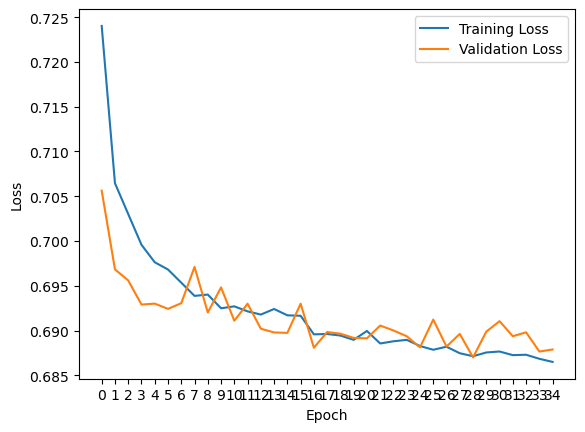

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardize the features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Convert data to PyTorch tensors
X = torch.tensor(data[features].values, dtype=torch.float32)
y = torch.tensor(data['target'].values, dtype=torch.float32)  # For BCE loss, use float labels
# weights_nominal = torch.tensor(data['weight_nominal_scaled'].values, dtype=torch.float32) # Use this one for saving the weights when balancing by removing
weights_nominal = torch.tensor(data['weight_nominal'].values, dtype=torch.float32)
weights_balance = torch.tensor(data['weight_balance'].values, dtype=torch.float32)

# Split data into training+validation and test sets (80/20)
X_train_val, X_test, y_train_val, y_test, wn_train_val, wn_test, wb_train_val, wb_test = train_test_split(X, y, weights_nominal, weights_balance, test_size=0.2, random_state=42)

# Further split the training data into train and validation sets (80/20 of 80%)
X_train, X_val, y_train, y_val, wn_train, wn_val, wb_train, wb_val  = train_test_split(X_train_val, y_train_val, wn_train_val, wb_train_val, test_size=0.2, random_state=42)

# Create DataLoaders for each set
train_loader = DataLoader(TensorDataset(X_train, y_train, wn_train, wb_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val, wn_val, wb_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test, wn_test, wb_test), batch_size=64, shuffle=False)

# Define the model
n_features = len(features)

class SimpleNN(nn.Module):
    def __init__(self, n_layers=1, n_neurons=64):
        super(SimpleNN, self).__init__()

        layers = []
        layers.append(nn.Linear(n_features, n_neurons))
        layers.append(nn.BatchNorm1d(n_neurons))  # Add BatchNorm after the input layer

        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
            layers.append(nn.BatchNorm1d(n_neurons))  # Add BatchNorm after each hidden layer
            
        layers.append(nn.Linear(n_neurons, 1)) # Final layer with 1 neuron for binary classification

        self.layers = nn.ModuleList(layers)
        self.sigmoid = nn.Sigmoid() 

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # x = self.sigmoid(self.layers[-1](x)) #Temp moved
        x = self.layers[-1](x) # USE THIS LINE FOR BCEWithLogitsLoss
        return x

model = SimpleNN(n_layers=3, n_neurons=32) # This is where we define the model

# Loss and optimizer
# criterion = nn.BCELoss(reduction="mean")  # Binary cross entropy 
# criterion = nn.BCELoss(reduction="none")  # Binary cross entropy for when we do weight balancing
# criterion = nn.BCEWithLogitsLoss(reduction="mean")  # Binary cross entropy with logits
criterion = nn.BCEWithLogitsLoss(reduction="none")  # Binary cross entropy with logits with weight balancing
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model with validation tracking
n_epochs = 20
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Training phase
    model.train()
    running_train_loss = 0.0
    for batch_x, batch_y, batch_wn, batch_wb in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        batch_y = batch_y.view(-1, 1)  # Reshape to match output shape
        loss = criterion(outputs, batch_y)

        # Apply weights
        weighted_loss = loss * batch_wb # Multiplies the loss (vecotr size of batch) by the balncing weight (1 for backgorund, 6ish for signal)
        weighted_loss_mean = weighted_loss.mean() # Take the mean of the weighted loss

        # loss.backward()
        weighted_loss_mean.backward()
        
        optimizer.step()
        # running_train_loss += loss.item() * batch_x.size(0)
        running_train_loss += weighted_loss_mean.item() * batch_x.size(0)

        
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y, batch_wn, batch_wb in val_loader:
            outputs = model(batch_x)
            batch_y = batch_y.view(-1, 1)
            val_loss = criterion(outputs, batch_y)
            weighted_val_loss = val_loss * batch_wb
            weighted_val_loss_mean = weighted_val_loss.mean()

            # running_val_loss += val_loss.item() * batch_x.size(0)
            running_val_loss += weighted_val_loss_mean.item() * batch_x.size(0)


    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{n_epochs}], Training Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')

# Plot the training and validation losses
plt.plot(range(n_epochs), train_losses, label='Training Loss')
plt.plot(range(n_epochs), val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(range(n_epochs))
plt.legend()
plt.show()


[0.11069275 0.19180848 0.2895249  ... 0.04193352 0.5284484  0.13770024]


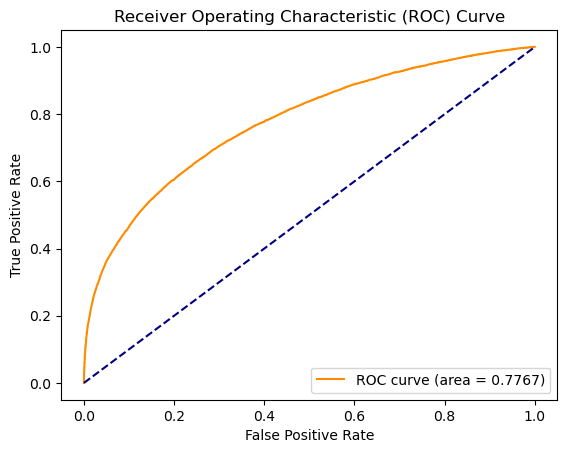

In [22]:
import torch
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Collect all predictions and true labels
all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays
all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
print(all_outputs)
all_labels = np.array(all_labels)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_outputs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")  # Diagonal line for random performance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [23]:
from torchinfo import summary
summary(model, input_size=(32, n_features))  # Replace 64 with your batch size


Layer (type:depth-idx)                   Output Shape              Param #
SimpleNN                                 [32, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─Linear: 2-1                       [32, 32]                  640
│    └─BatchNorm1d: 2-2                  [32, 32]                  64
│    └─Linear: 2-3                       [32, 32]                  1,056
│    └─BatchNorm1d: 2-4                  [32, 32]                  64
│    └─Linear: 2-5                       [32, 32]                  1,056
│    └─BatchNorm1d: 2-6                  [32, 32]                  64
│    └─Linear: 2-7                       [32, 1]                   33
Total params: 2,977
Trainable params: 2,977
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.01
Estimated Total Size (MB): 0.06

### Histogram output plots

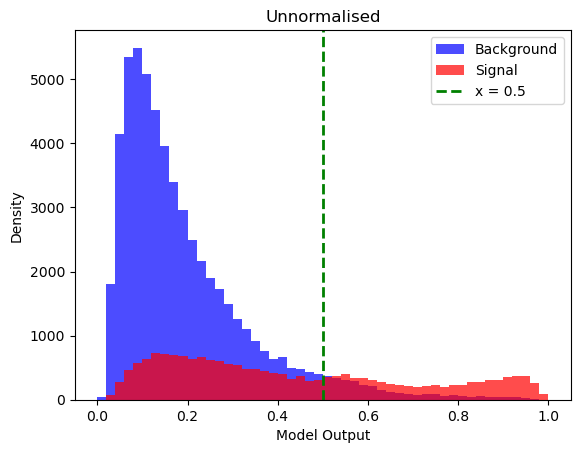

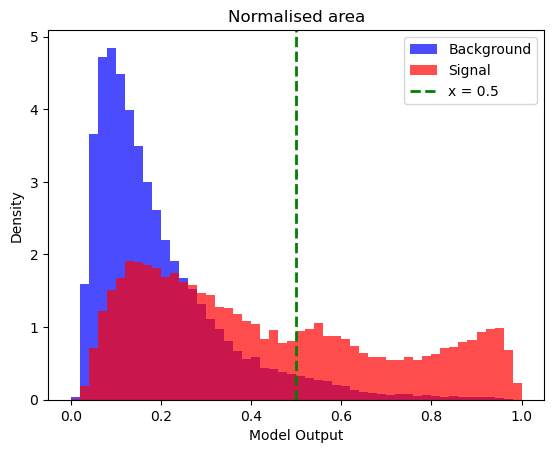

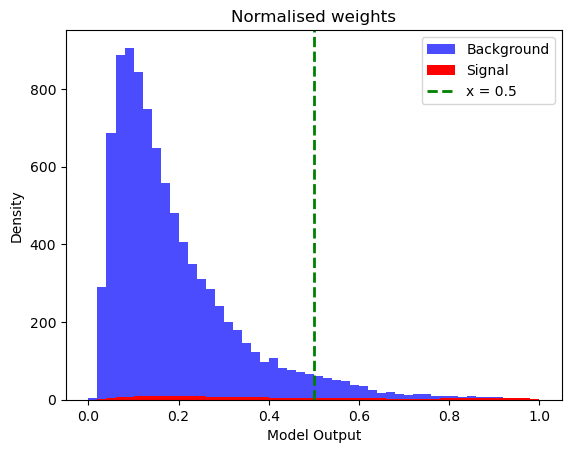

In [24]:
# Plot a hisogram of the model outputs for signal and background
model.eval()

# Collect all predictions and true labels

all_outputs = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y, batch_wn, batch_wb in test_loader:
        # Get model outputs (logits if using BCEWithLogitsLoss)
        outputs = model(batch_x)
        
        # Apply sigmoid if necessary to get probabilities
        probs = torch.sigmoid(outputs).numpy()  # Convert to numpy for compatibility
        all_outputs.extend(probs)
        all_labels.extend(batch_y.numpy())

# Convert lists to numpy arrays

all_outputs = np.array(all_outputs).flatten()  # Flatten to a 1D array
all_labels = np.array(all_labels)

# Plot the model outputs for signal and background

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1),alpha = 0.7, label='Signal', color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Unnormalised")
plt.legend()
plt.show()

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', density='true', color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1),alpha = 0.7, label='Signal', density='true', color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised area")
plt.legend()
plt.show()

plt.hist(all_outputs[all_labels == 0], bins=50, range=(0, 1),alpha = 0.7, label='Background', weights=wn_test[all_labels == 0]*200000, color='b')
plt.hist(all_outputs[all_labels == 1], bins=50, range=(0, 1), label='Signal',  weights=wn_test[all_labels == 1]*200000, color='r')
plt.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='x = 0.5')
plt.xlabel('Model Output')
plt.ylabel('Density')
plt.title("Normalised weights")
plt.legend()
plt.show()

/tmp/ipykernel_2377224/3333641786.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wn_test_array = np.array(wn_test*200000)


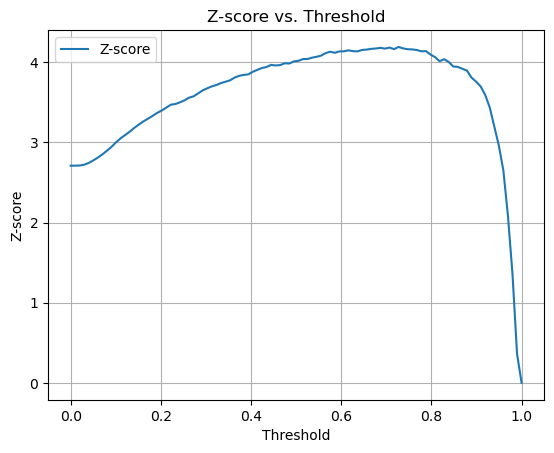

In [18]:
# Assume w_test is the array of weights for each sample in the test set
wn_test_array = np.array(wn_test*200000)

# Define thresholds between 0 and 1
thresholds = np.linspace(0, 1, 100)
z_scores = []

# Calculate the Z-score for each threshold using weights
for threshold in thresholds:
    # Weighted count of signal predictions above the threshold
    S = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 1)])  # Weighted Signal
    B = np.sum(wn_test_array[(all_outputs > threshold) & (all_labels == 0)])  # Weighted Background

    # Calculate Z-score (add small epsilon to avoid division by zero)
    if S + B > 0:
        Z = S / np.sqrt(S + B + 1e-10)  # 1e-10 to avoid division by zero
    else:
        Z = 0  # Define Z as 0 if S + B is 0

    z_scores.append(Z)

# Plot Z-score vs. Threshold
plt.plot(thresholds, z_scores, label="Z-score")
plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title("Z-score vs. Threshold")
plt.legend()
plt.grid()
plt.show()
